In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit, float64
from CG import CG
from ASM import ASM
from SINewton import SINewton
from FindInitGuess import FindInitGuess
from SG import SG

In [2]:
df_2016 = pd.read_csv('A2016.csv').dropna(axis = 0)
df_2012 = pd.read_csv('A2012.csv').dropna(axis = 0)

In [3]:
print(df_2016)

       FIPS                 County      DEM      GOP  MedianIncome  MigraRate  \
0      1001     Autauga County, AL   5908.0  18110.0       54487.0        5.3   
1      1003     Baldwin County, AL  18409.0  72780.0       56460.0       21.5   
2      1005     Barbour County, AL   4848.0   5431.0       32884.0      -18.2   
3      1007        Bibb County, AL   1874.0   6733.0       43079.0       -0.8   
4      1009      Blount County, AL   2150.0  22808.0       47213.0       -1.0   
...     ...                    ...      ...      ...           ...        ...   
3138  56037  Sweetwater County, WY   3233.0  12153.0       74546.0      -17.9   
3139  56039       Teton County, WY   7313.0   3920.0       84118.0       -0.5   
3140  56041       Uinta County, WY   1202.0   6154.0       64713.0      -11.3   
3141  56043    Washakie County, WY    532.0   2911.0       49533.0      -15.2   
3142  56045      Weston County, WY    294.0   2898.0       56582.0        1.4   

      BirthRate  DeathRate 

In [4]:
Cali_data = df_2016[df_2016['County'].str.contains(', CA')]
n, dim = Cali_data.shape
idem = np.where(Cali_data['DEM'] >= Cali_data['GOP'])
irep = np.where(Cali_data['DEM'] < Cali_data['GOP'])
num = Cali_data['DEM'] + Cali_data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1

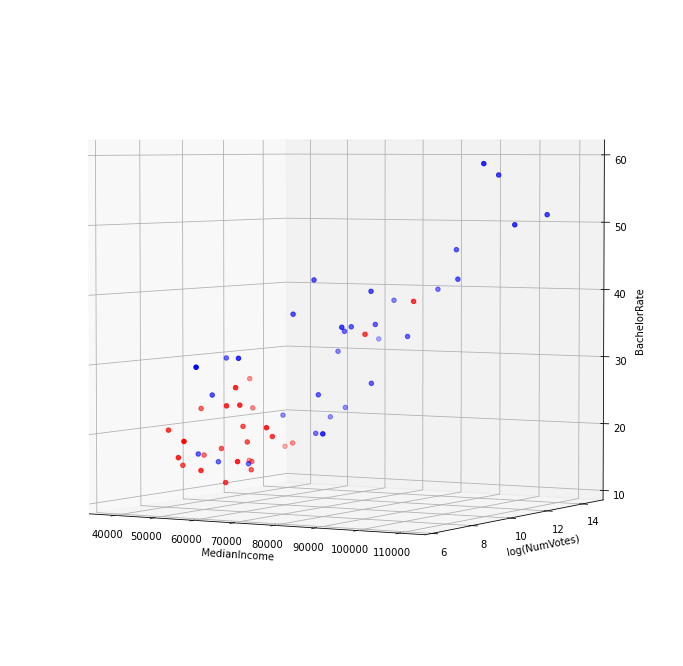

In [5]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
X  = Cali_data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
ax.scatter(X.iloc[idem].iloc[:,i1],X.iloc[idem].iloc[:,i2],X.iloc[idem].iloc[:,i3],c = 'b')
ax.scatter(X.iloc[irep].iloc[:,i1],X.iloc[irep].iloc[:,i2],X.iloc[irep].iloc[:,i3],c = 'r')
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

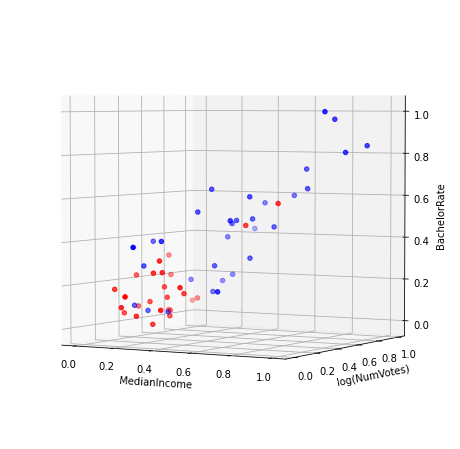

In [6]:
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
XX = X.iloc[:,[i1,i2,i3]].values
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

In [7]:
(n, dim) = XX.shape
lam = 0.01
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w = np.array([-1,-1,1,1])

def fun0(I,Y,w,lam):
    f = np.sum(np.log(1 + np.exp(-Y[I,:] @ w)))/len(I) + 0.5*lam*np.dot(w,w)
    return f

def gfun0(I,Y,w,lam):
    aux = np.exp(-Y[I,:] @ w)
    d1 = Y.shape[1]
    g = np.sum(-Y[I,:] * (np.outer((aux/(1 + aux)),np.ones(d1))), axis = 0)/len(I) + lam*w
    return g

def Hvec0(I,Y,w,v,lam):
    aux = np.exp(-Y[I,:] @ w)
    d1 = Y.shape[1]
    Hv = np.sum(Y[I,:] * np.outer((aux * (Y[I,:] @ v)/(np.power((1+aux),2))),np.ones(d1)), axis = 0) + lam*v
    return Hv

fun = lambda I,Y,w: fun0(I,Y,w,lam)
gfun = lambda I,Y,w: gfun0(I,Y,w,lam)
Hvec = lambda I,Y,w,v: Hvec0(I,Y,w,v,lam)

In [8]:
w,f,gnorm = SINewton(fun,gfun,Hvec,Y,w)

4
k = 890, a = 8.962938e-15, f = 5.527956e-01


In [ ]:
wplotsvn = np.copy(w)
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-w[0]*xx -w[1]*yy-w[3])/w[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

plt.figure()
niter = len(f)
plt.plot(np.arange(niter),f)
plt.xlabel('k')
plt.ylabel('f')
plt.show()

plt.figure()
niter = len(gnorm)
plt.plot(np.arange(niter),gnorm)
plt.xlabel('k')
plt.ylabel('|| stoch grad f||')
plt.yscale('log')
plt.show()

In [ ]:
def fun0SB(x,d,C):
    M = np.eye(x.size)
    M[d:,d:] = 0.
    v = np.zeros(x.size)
    v[d+1:] = 1.
    f = 0.5*np.dot(x,M @ x) + C*np.dot(v,x)
    return f

def gfun0SB(x,d,C):
    g = np.copy(x)
    g[d] = 0
    g[d+1:] = C
    return g

def Hfun0SB(x,d,C):
    H = np.eye(x.size)
    H[d:,d:] = 0
    return H

def RunASMwSB(XX, Y, C = 1e3):
    d = XX.shape[1]
    n = XX.shape[0]
    funSB = lambda x: fun0SB(x,d,C)
    gfunSB = lambda x: gfun0SB(x,d,C)
    HfunSB = lambda x: Hfun0SB(x,d,C)
    
    b = np.concatenate((np.ones(n),np.zeros(n)))
    At = np.concatenate((Y,np.eye(n)),axis = 1)
    Ab = np.concatenate((np.zeros((n,d+1)),np.eye(n)),axis = 1)
    A = np.concatenate((At,Ab))
    w = np.array([-1,-1,1,1])
    Aguess = Y
    bguess = np.ones(n)
    w, l, lcomp = FindInitGuess(w,Aguess,bguess)
    winit = np.append(w,lcomp)
    x, l2, lcom2 = FindInitGuess(winit, A, b)
    print(l2)
    W = np.where(A @ x == 0)[0]
    xiter, lm = ASM(x, gfunSB, HfunSB, A, b, W)
    return xiter, lm

In [ ]:
xiter, lm = RunASMwSB(XX, Y)

In [ ]:
wplot = xiter[-1,:4]
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplot[0]*xx -wplot[1]*yy-wplot[3])/wplot[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(30)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()


fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplotsvn[0]*xx -wplotsvn[1]*yy-wplotsvn[3])/wplotsvn[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(30)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

In [ ]:
searchfor = [', CA', ', OR']
data = df_2016[df_2016['County'].str.contains('|'.join(searchfor))]
n, dim = data.shape
idem = np.where(data['DEM'] >= data['GOP'])
irep = np.where(data['DEM'] < data['GOP'])
num = data['DEM'] + data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1
X  = data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
XX = X.iloc[:,[i1,i2,i3]].values
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
n, dim = XX.shape
lam = 0.01
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w = np.array([-1,-1,1,1])

wplotsvn,f,gnorm = SINewton(fun,gfun,Hvec,Y,w)

xiter, lm = RunASMwSB(XX,Y,C = 1e3)
wplot = xiter[-1,:4]

fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplot[0]*xx -wplot[1]*yy-wplot[3])/wplot[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()


fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplotsvn[0]*xx -wplotsvn[1]*yy-wplotsvn[3])/wplotsvn[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

In [ ]:
searchfor = [', CA', ', OR', ', WA',', NJ', ', NY']
data = df_2016[df_2016['County'].str.contains('|'.join(searchfor))]
n, dim = data.shape
idem = np.where(data['DEM'] >= data['GOP'])
irep = np.where(data['DEM'] < data['GOP'])
num = data['DEM'] + data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1
X  = data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
XX = X.iloc[:,[i1,i2,i3]].values
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
n, dim = XX.shape
lam = 0.005
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w = np.array([-1,-1,1,1])

wplotsvn,f,gnorm = SINewton(fun,gfun,Hvec,Y,w,batchsize = 100)

xiter, lm = RunASMwSB(XX,Y, C = 1e2)
wplot = xiter[-1,:4]

fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplot[0]*xx -wplot[1]*yy-wplot[3])/wplot[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(10,20)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()


fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplotsvn[0]*xx -wplotsvn[1]*yy-wplotsvn[3])/wplotsvn[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(10,20)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

In [ ]:
idem = np.where(df_2016['DEM'] >= df_2016['GOP'])[0]
repmask = np.ones(df_2016.shape[0])
repmask[idem] = 0
repmask = np.array(repmask, dtype = bool)
rep_data = df_2016.iloc[repmask]
dem_data = df_2016.iloc[idem,:]
rand_rep_counties = np.random.permutation(rep_data.shape[0])[:len(idem)]
rep_data = rep_data.iloc[rand_rep_counties,:]
data = dem_data.append(rep_data)
n = data.shape[0]
idem = np.where(data['DEM'] >= data['GOP'])
irep = np.where(data['DEM'] < data['GOP'])
num = data['DEM'] + data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1
X  = data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
XX = X.iloc[:,[i1,i2,i3]].values
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
(n, dim) = XX.shape
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w = np.array([-1,-1,1,1])

In [ ]:
def aconst0(itr, a):
    return a

def aitr(itr):
    return 1/(itr+1)

def ahalf0(itr, m0, a):
    if itr < m0:
        return a
    elif itr >= m0 and itr < 2*m0:
        return a/2
    else:
        red_itr = itr - 2*m0
        kitr = 2
        ksum = 2**kitr/kitr
        while red_itr >= ksum:
            kitr += 1
            ksum += 2**kitr/kitr
        return 2**(-kitr)*a

In [ ]:
maxiter = 5000
trials = 1000
a_vals = np.logspace(-3,0,4)
lams = np.array([1e-4,1e-2,1])
m0 = 100
batchsizes = np.array([16,32,64,128])
from tqdm import tqdm
total_iters = len(lams)*len(a_vals)*len(batchsizes)*trials*2 + len(lams)*len(batchsizes)*trials

fmat = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
gradnormmat = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
xfin = np.zeros((trials,w.size,len(lams),len(a_vals),len(batchsizes)))

fmathalf = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
gradnormmathalf = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
xfinhalf = np.zeros((trials,w.size,len(lams),len(a_vals),len(batchsizes)))

fmatitr = np.zeros((trials,maxiter+1,len(lams),len(batchsizes)))
gradnormmatitr = np.zeros((trials,maxiter+1,len(lams),len(batchsizes)))
xfinitr = np.zeros((trials,w.size,len(lams),len(batchsizes)))

with tqdm(total = total_iters) as pbar:
    for i in range(len(lams)):

        fun = lambda I,Y,w: fun0(I,Y,w,lams[i])
        gfun = lambda I,Y,w: gfun0(I,Y,w,lams[i])
        Hvec = lambda I,Y,w,v: Hvec0(I,Y,w,v,lams[i])

        for j in range(len(a_vals)):
            aconst = lambda itr: aconst0(itr,a_vals[j])
            ahalf = lambda itr: ahalf0(itr, m0, a_vals[j])
            if j == 0:
                for k in range(len(batchsizes)):
                    for l in range(trials):
                        xiter, fmat[l,:,i,j,k], gradnormmat[l,:,i,j,k] = SG(fun, gfun, Y, w, aconst,batchsize = batchsizes[k], itermax = maxiter)
                        xfin[l,:,i,j,k] = xiter[-1,:w.size]
                        pbar.update(1)
                        xiter, fmatitr[l,:,i,k], gradnormmatitr[l,:,i,k] = SG(fun, gfun, Y, w, aitr,batchsize = batchsizes[k], itermax = maxiter)
                        xfinitr[l,:,i,k] = xiter[-1,:w.size]
                        pbar.update(1)
                        xiter, fmathalf[l,:,i,j,k], gradnormmathalf[l,:,i,j,k] = SG(fun, gfun, Y, w, ahalf,batchsize = batchsizes[k], itermax = maxiter)
                        xfinhalf[l,:,i,j,k] = xiter[-1,:w.size]
                        pbar.update(1)
                    np.savetxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(fmat[:,:,i,j,k],axis = 0),delimiter = ',')
                    np.savetxt('Data/SG_fvals_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(fmatitr[:,:,i,k],axis = 0), delimiter = ',')
                    np.savetxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(fmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    np.savetxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(gradnormmat[:,:,i,j,k],axis = 0),delimiter = ',')
                    np.savetxt('Data/SG_gradnorm_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(gradnormmatitr[:,:,i,k],axis = 0), delimiter = ',')
                    np.savetxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(gradnormmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    np.savetxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), xfin[:,:,i,j,k],delimiter = ',')
                    np.savetxt('Data/SG_xfin_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), xfinitr[:,:,i,k], delimiter = ',')
                    np.savetxt('Data/SG_xfin_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), xfinhalf[:,:,i,j,k], delimiter = ',')
                #print(i,j,k)
            else:
                for k in range(len(batchsizes)):
                    for l in range(trials):
                        xiter, fmat[l,:,i,j,k], gradnormmat[l,:,i,j,k] = SG(fun, gfun, Y, w, aconst,batchsize = batchsizes[k], itermax = maxiter)
                        xfin[l,:,i,j,k] = xiter[-1,:w.size]
                        pbar.update(1)
                        xiter, fmathalf[l,:,i,j,k], gradnormmathalf[l,:,i,j,k] = SG(fun, gfun, Y, w, ahalf,batchsize = batchsizes[k], itermax = maxiter)
                        xfinhalf[l,:,i,j,k] = xiter[-1,:w.size]
                        pbar.update(1)
                    np.savetxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(fmat[:,:,i,j,k],axis = 0),delimiter = ',')
                    np.savetxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(fmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    np.savetxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(gradnormmat[:,:,i,j,k],axis = 0),delimiter = ',')
                    np.savetxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(gradnormmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    np.savetxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), xfin[:,:,i,j,k],delimiter = ',')
                    np.savetxt('Data/SG_xfin_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), xfinhalf[:,:,i,j,k], delimiter = ',')
                #print(i,j,k)

In [ ]:
fmatitr = np.zeros((trials,maxiter+1))
gradnormmatitr = np.zeros((trials,maxiter+1))
xfinitr = np.zeros((trials,w.size))

a = 1
m0 = 10
ahalf = lambda itr: ahalf0(itr,m0,a)

fmathalf = np.zeros((trials,maxiter+1))
gradnormmathalf = np.zeros((trials,maxiter+1))
xfinhalf = np.zeros((trials,w.size))


for i in range(trials):
    xiter, fmatitr[i], gradnormmatitr[i] = SG(fun, gfun, Y, w, aitr)
    xfinitr[i] = xiter[-1,:w.size]
    xiter, fmathalf[i], gradnormmathalf[i] = SG(fun, gfun, Y, w, ahalf)
    xfinhalf[i] = xiter[-1,:w.size]
    if i % 25 == 0:
        print('Trial %d' % i)

In [ ]:
a = 0.1
m0 = 300
ahalf = lambda itr: ahalf0(itr,m0,a)

fmathalf = np.zeros((trials,maxiter+1))
gradnormmathalf = np.zeros((trials,maxiter+1))
xfinhalf = np.zeros((trials,w.size))


for i in range(trials):
    xiter, fmathalf[i], gradnormmathalf[i] = SG(fun, gfun, Y, w, ahalf)
    xfinhalf[i] = xiter[-1,:w.size]
    if i % 25 == 0:
        print('Trial %d' % i)

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(np.arange(maxiter+1),np.mean(fmat,axis = 0),label = 'Constant a = 0.01')
plt.plot(np.arange(maxiter+1),np.mean(fmatitr,axis = 0),label = 'a = 1/k')
plt.plot(np.arange(maxiter+1),np.mean(fmathalf,axis = 0),label = r'$m_0 = 10$, $a = 2^{-k}*a_0$, $a_0 = 1$')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('f(x)')
plt.show()

plt.figure(figsize = (8,8))
plt.plot(np.arange(maxiter),np.mean(gradnormmat[:,:maxiter],axis = 0),label = 'Constant a = 0.01')
plt.plot(np.arange(maxiter),np.mean(gradnormmatitr[:,:maxiter],axis = 0),label = 'a = 1/k')
plt.plot(np.arange(maxiter),np.mean(gradnormmathalf[:,:maxiter],axis = 0),label = r'$m_0 = 10$, $a = 2^{-k}*a_0$, $a_0 = 1$')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.show()